In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import numpy as np
import seaborn as sns
import os

ModuleNotFoundError: No module named 'sklearn'

# Data preparation

In [3]:
path = "data/"

In [4]:
states = ["idle", "running", "stairs", "walking"]

df = pd.DataFrame(columns=[
    'state',
    'x_mean', 'x_max', 'x_min', 'x_std', 'x_var', 'x_median', 'x_range', 'x_rms',
    'y_mean', 'y_max', 'y_min', 'y_std', 'y_var', 'y_median', 'y_range', 'y_rms',
    'z_mean', 'z_max', 'z_min', 'z_std', 'z_var', 'z_median', 'z_range', 'z_rms'
])

def compute_features(column):
    features = {
        'mean': column.mean(),
        'max': column.max(),
        'min': column.min(),
        'std': column.std(),
        'var': column.var(),
        'median': column.median(),
        'range': column.max() - column.min(),
        'rms': np.sqrt(np.mean(column**2))
    }
    return features

In [5]:
for state in states:
  files_list = os.listdir(f"{path}{state}")
  for file_name in files_list:
    current_path = f"{path}{state}/{file_name}"
    data = pd.read_csv(current_path)
    x = data[data.columns[0]]
    y = data[data.columns[1]]
    z = data[data.columns[2]]

    x_features = compute_features(x)
    y_features = compute_features(y)
    z_features = compute_features(z)

    new_data = pd.DataFrame({
            'state': [state],
            'x_mean': [x_features['mean']], 'x_max': [x_features['max']], 'x_min': [x_features['min']], 'x_std': [x_features['std']],
            'x_var': [x_features['var']], 'x_median': [x_features['median']], 'x_range': [x_features['range']], 'x_rms': [x_features['rms']],
            'y_mean': [y_features['mean']], 'y_max': [y_features['max']], 'y_min': [y_features['min']], 'y_std': [y_features['std']],
            'y_var': [y_features['var']], 'y_median': [y_features['median']], 'y_range': [y_features['range']], 'y_rms': [y_features['rms']],
            'z_mean': [z_features['mean']], 'z_max': [z_features['max']], 'z_min': [z_features['min']], 'z_std': [z_features['std']],
            'z_var': [z_features['var']], 'z_median': [z_features['median']], 'z_range': [z_features['range']], 'z_rms': [z_features['rms']]
    })

    df = pd.concat([df, new_data], ignore_index = True)

## Graphs of computed features

In [6]:
def graph(column):
  plt.plot(df["state"], df[column], ".")
  plt.grid(True)
  plt.xlabel("state")
  plt.ylabel(column)
  plt.show()

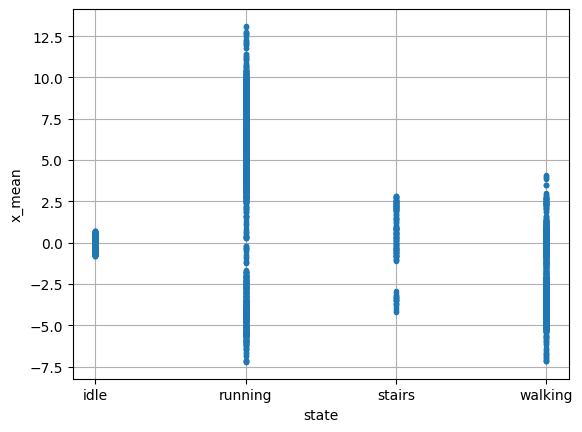

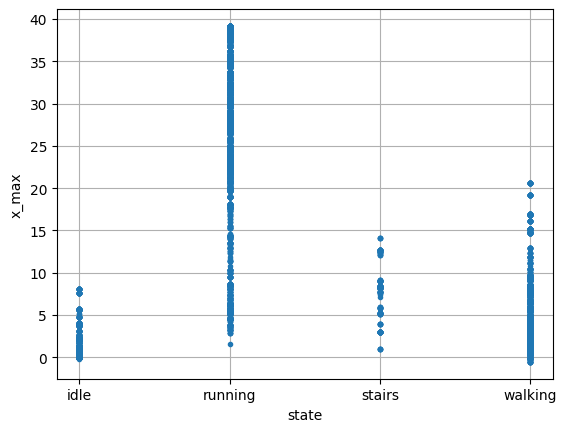

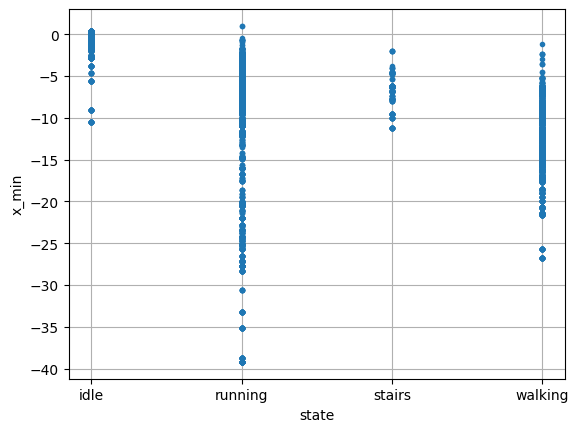

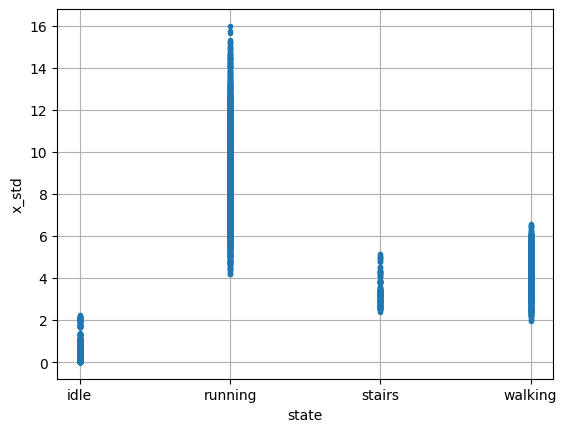

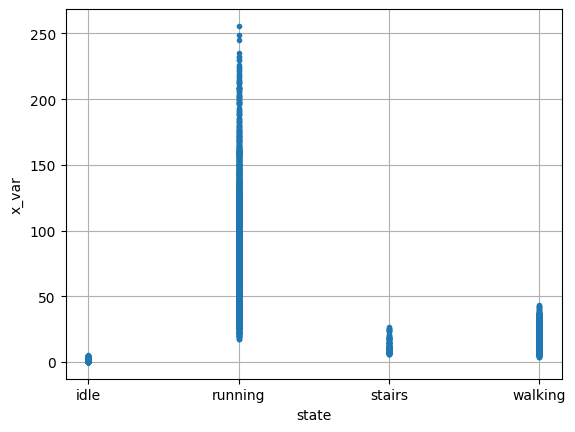

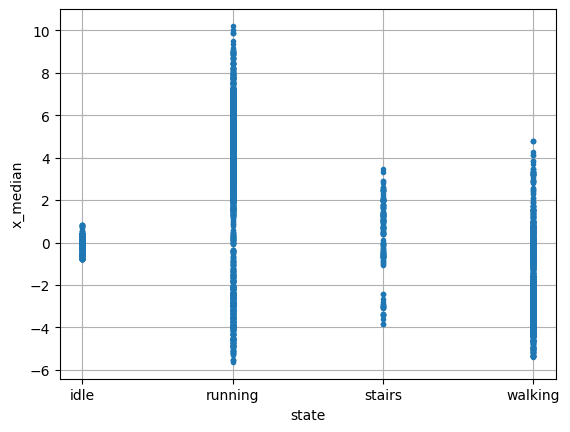

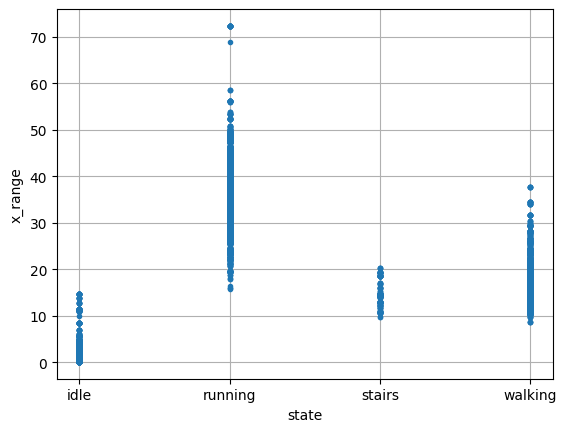

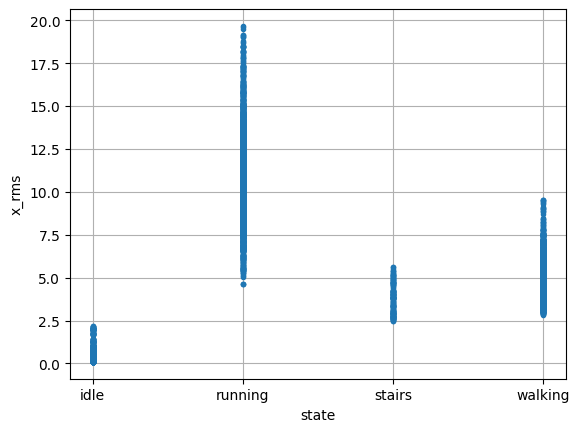

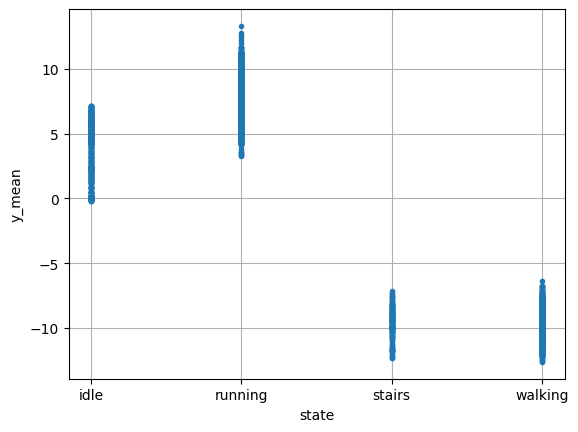

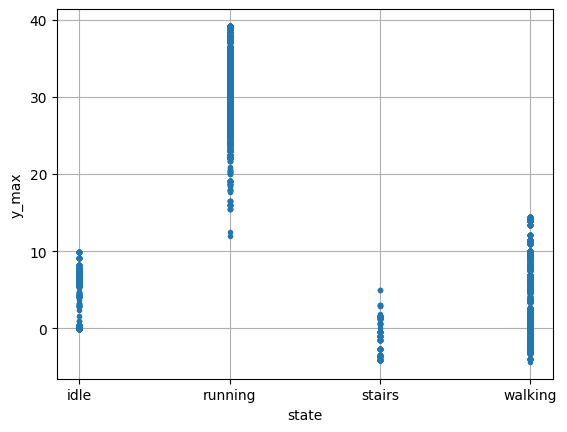

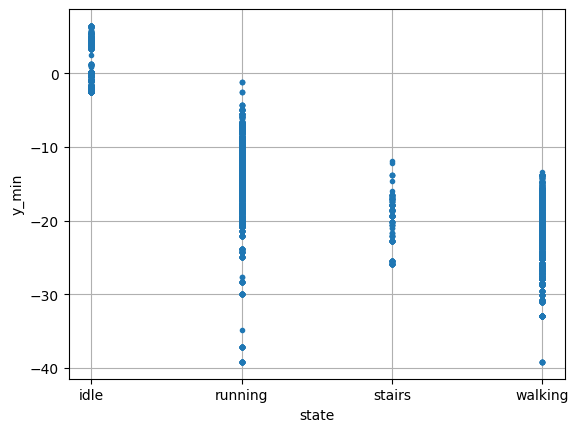

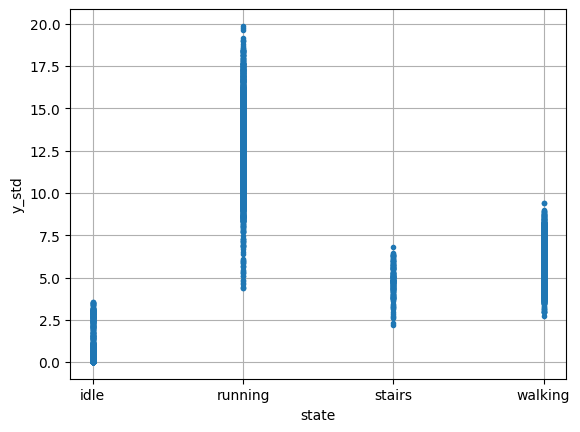

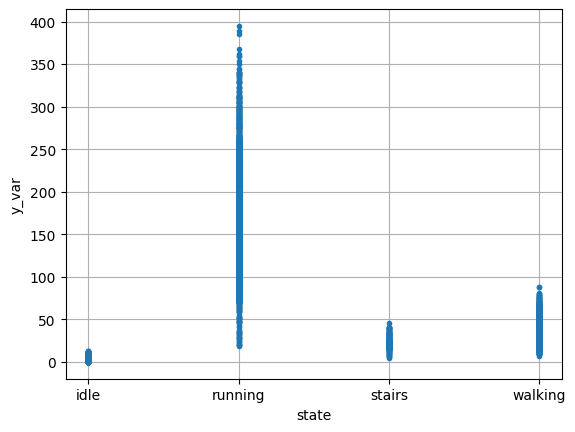

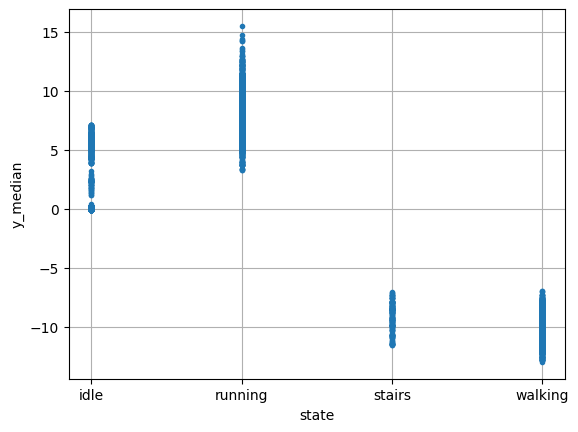

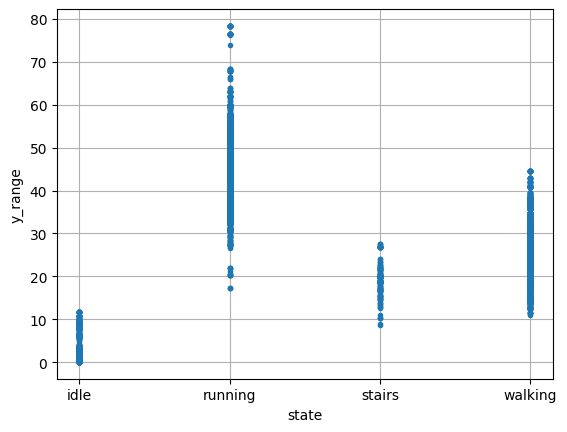

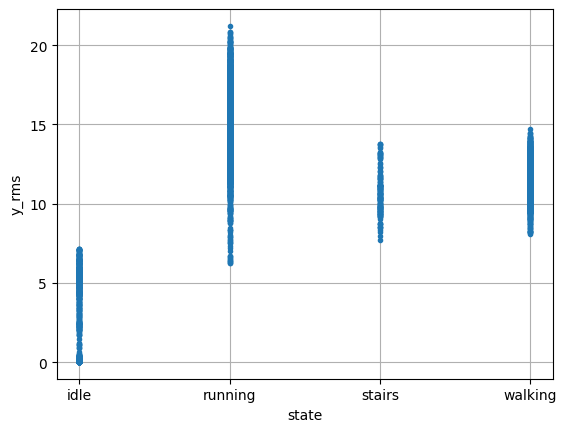

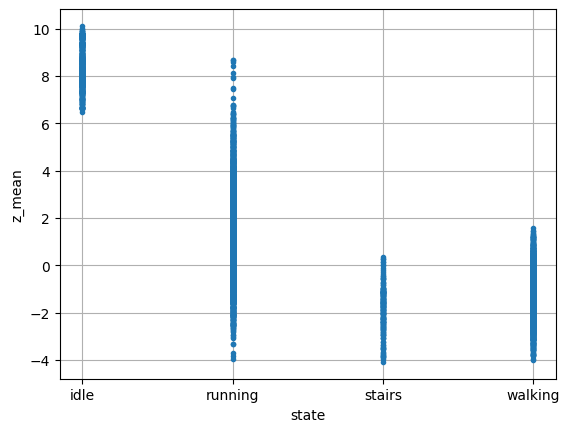

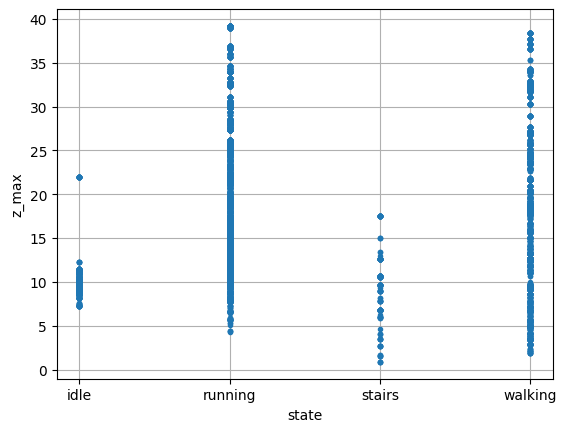

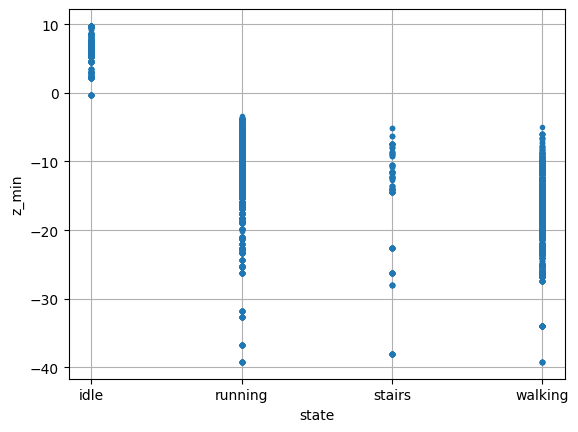

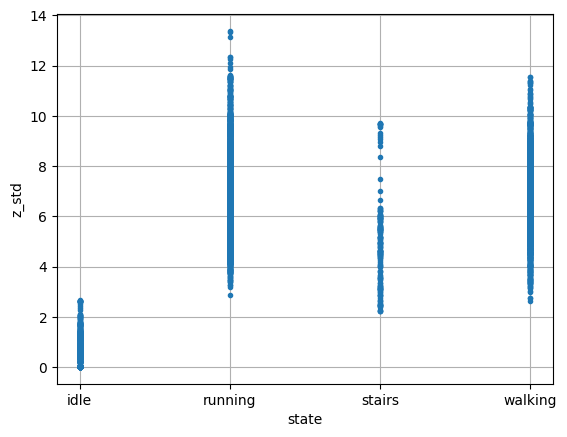

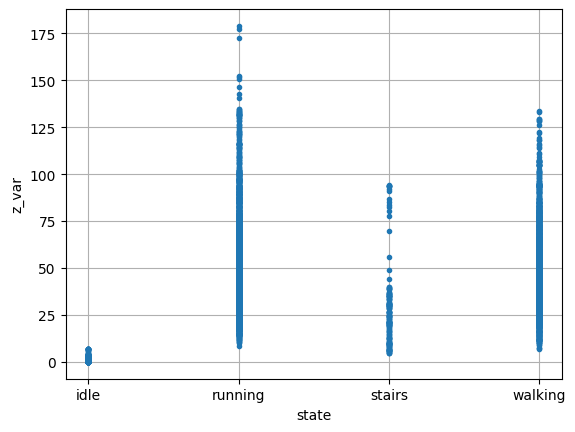

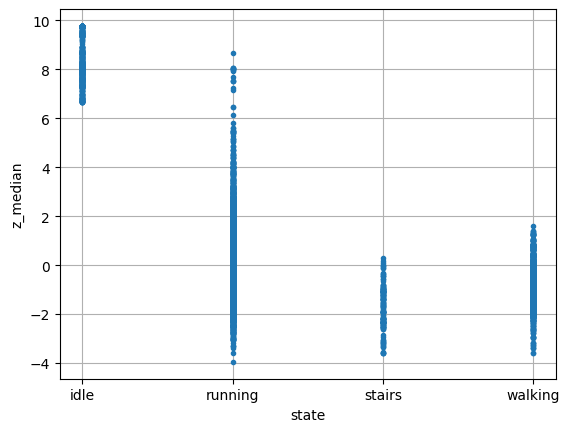

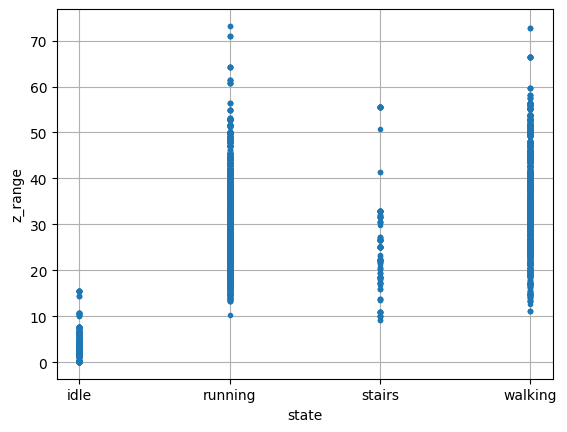

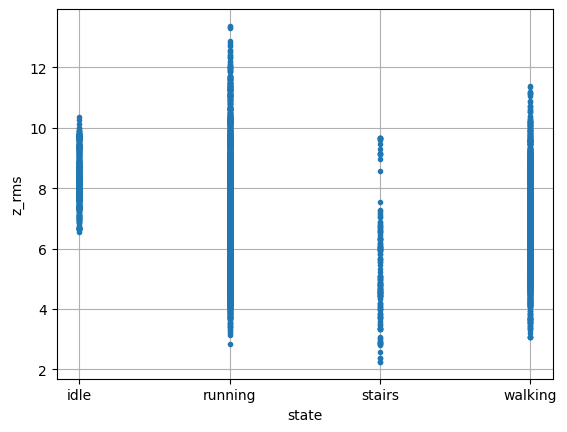

In [7]:
for column in df.columns[1:]:
  graph(column)

In [8]:
X = df[df.columns[1:]]
y = df["state"]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.4, random_state=11)

# SVM model

In [15]:
svm_classifier = SVC(random_state=11)
svm_classifier.fit(X_train, y_train)

svm_y_pred = svm_classifier.predict(X_test)

svm_accuracy = accuracy_score(y_test, svm_y_pred)
print(f"Accuracy: {svm_accuracy * 100:.2f}%")

Accuracy: 99.19%


## Visualization of model accuracy

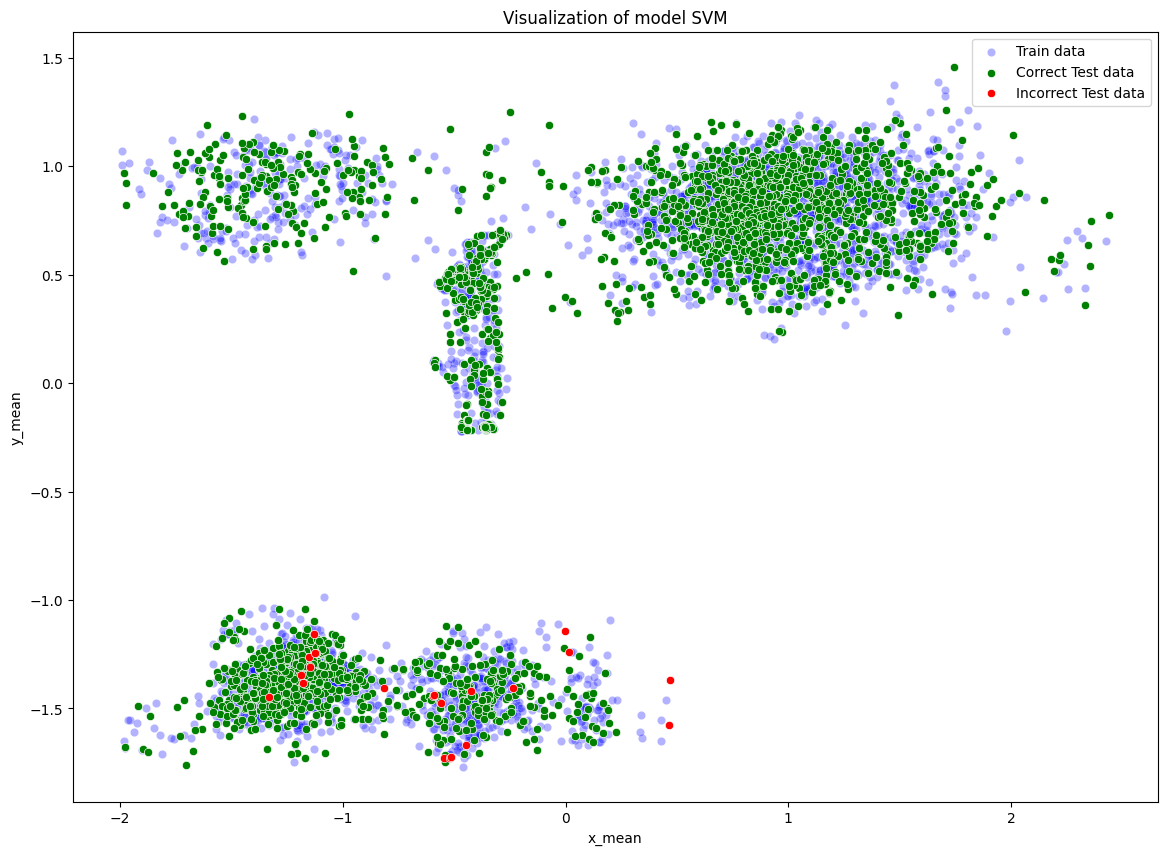

In [16]:
train_data = pd.DataFrame(X_train, columns=df.columns[1:])
train_data['state'] = y_train.values
train_data['set'] = 'train'

test_data = pd.DataFrame(X_test, columns=df.columns[1:])
test_data['state'] = y_test.values
test_data['predicted_state'] = svm_y_pred
test_data['set'] = 'test'
test_data['correct'] = test_data['state'] == test_data['predicted_state']

test_data['correct'] = test_data['correct'].astype(bool)

plot_data = pd.concat([train_data, test_data], ignore_index=True)

plt.figure(figsize=(14, 10))
sns.scatterplot(data=plot_data[plot_data['set'] == 'train'], x='x_mean', y='y_mean', color='blue', alpha=0.3, label='Train data')
sns.scatterplot(data=plot_data[(plot_data['set'] == 'test') & (plot_data['correct'] == True)], x='x_mean', y='y_mean', color='green', label='Correct Test data')
sns.scatterplot(data=plot_data[(plot_data['set'] == 'test') & (plot_data['correct'] == False)], x='x_mean', y='y_mean', color='red', label='Incorrect Test data')

plt.title('Visualization of model SVM')
plt.xlabel('x_mean')
plt.ylabel('y_mean')
plt.legend()
plt.show()

## Misclassifications

In [17]:
misclassifications = test_data[test_data['correct'] == False]
misclass_counts = misclassifications.groupby(['state', 'predicted_state']).size().reset_index(name='count')

print("Misclassifications:")
for index, row in misclass_counts.iterrows():
    print(f"{row['state']} - {row['count']} classificated as {row['predicted_state']}")

Misclassifications:
stairs - 18 classificated as walking
walking - 3 classificated as stairs


## Summary

In summary, the trained model achieved an accuracy of 99.19% and made 21 mistakes. The states that were confused were "stairs" and "walking" both ways, but "stairs" was more often incorrectly interpreted as "walking" than the other way around.

# Decision tree Model

In [27]:
dt_classifier = DecisionTreeClassifier(random_state=11)
dt_classifier.fit(X_train, y_train)

DecisionTreeClassifier(random_state=11)

## Decision tree

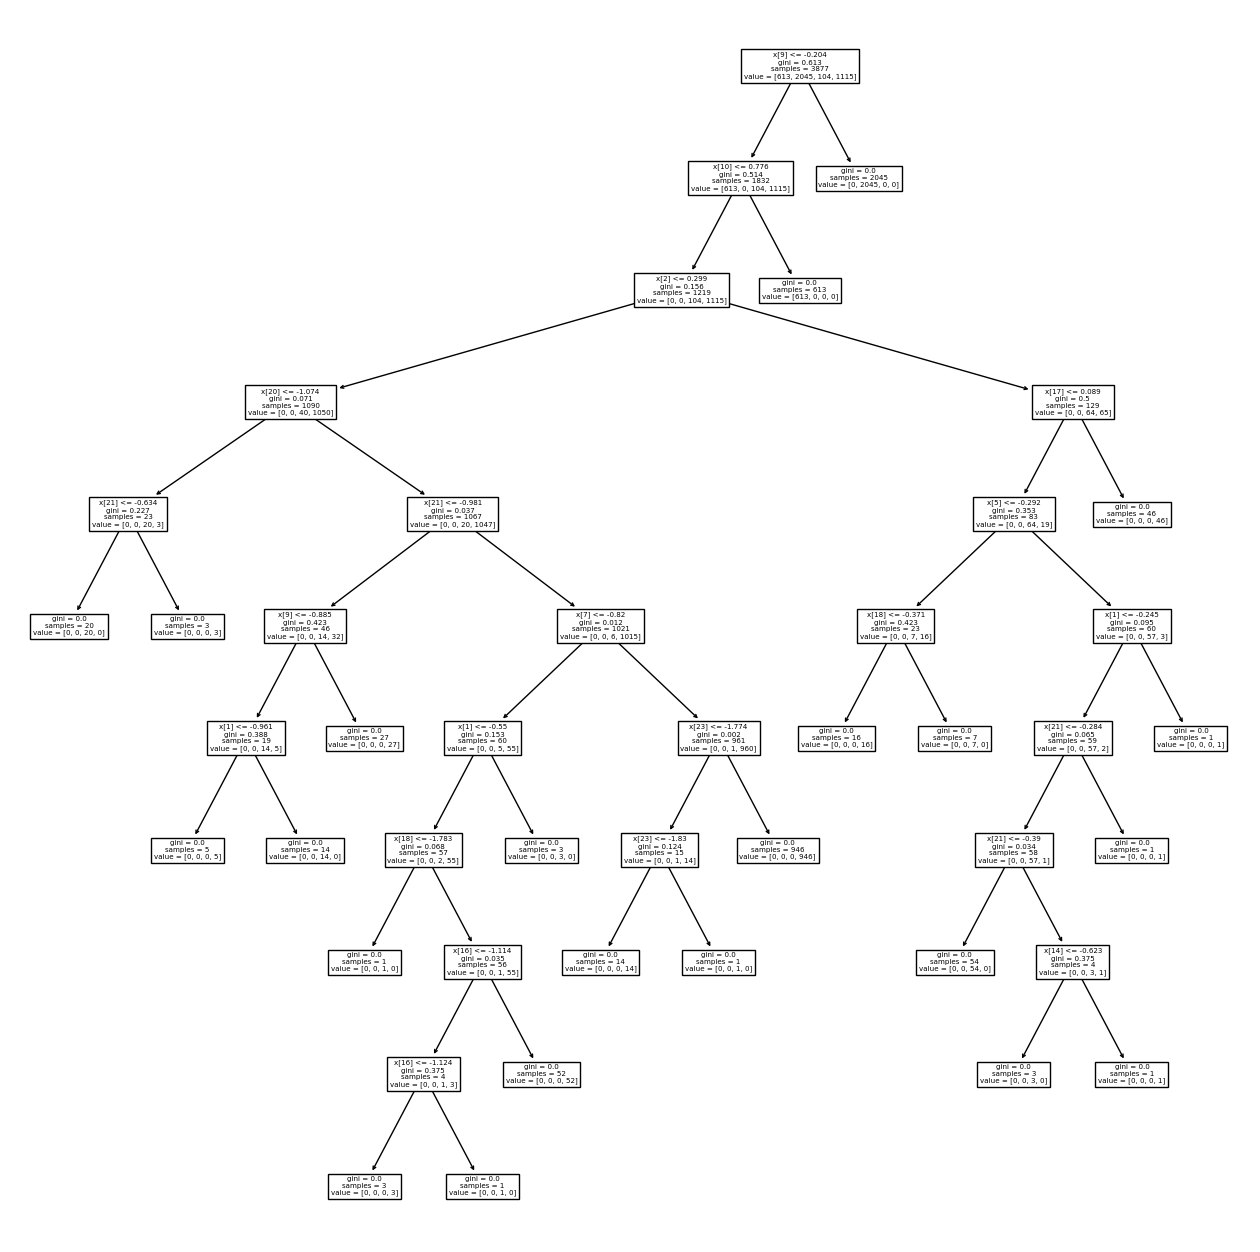

In [28]:
plt.figure(figsize=(16,16))
plot_tree(dt_classifier)
plt.show()

In [29]:
dt_y_pred = dt_classifier.predict(X_test)

dt_accuracy = accuracy_score(y_test, dt_y_pred)
print(f"Accuracy: {dt_accuracy * 100:.2f}%")

Accuracy: 99.50%


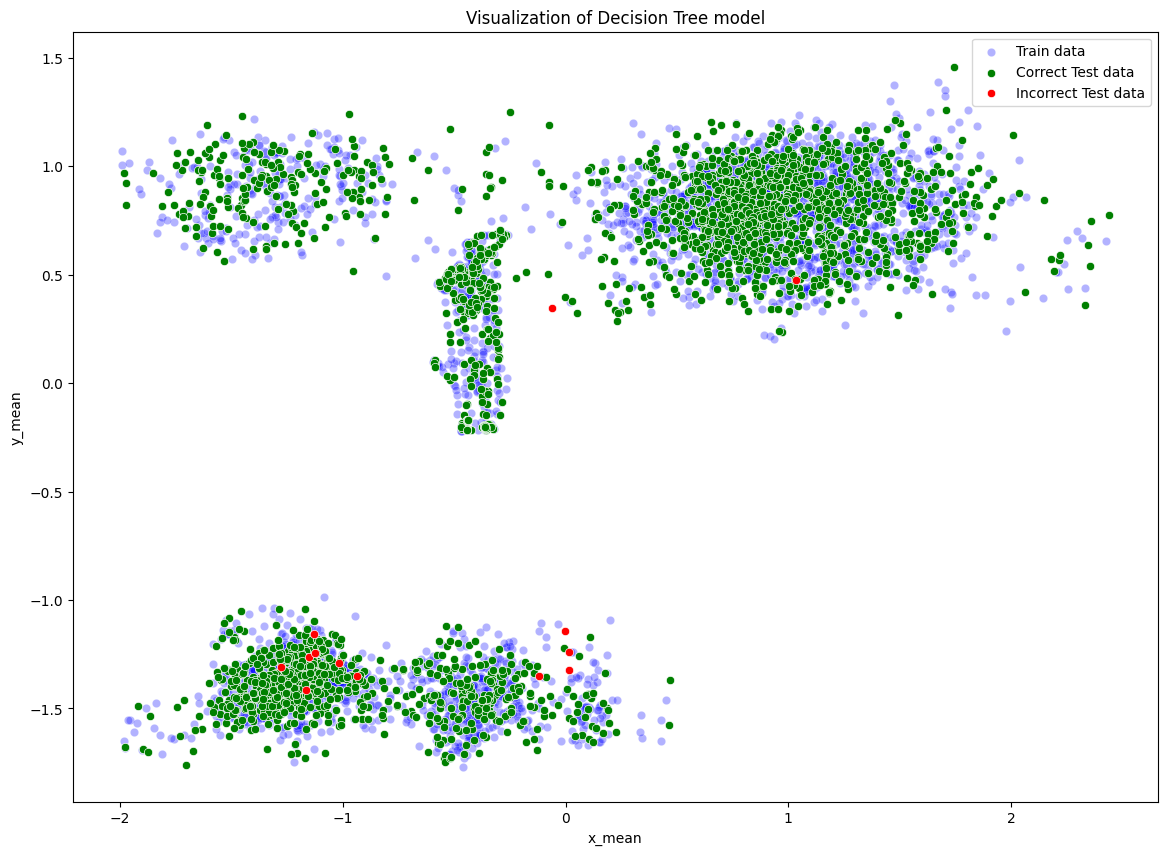

In [30]:
train_data = pd.DataFrame(X_train, columns=df.columns[1:])
train_data['state'] = y_train.values
train_data['set'] = 'train'

test_data = pd.DataFrame(X_test, columns=df.columns[1:])
test_data['state'] = y_test.values
test_data['predicted_state'] = dt_y_pred
test_data['set'] = 'test'
test_data['correct'] = test_data['state'] == test_data['predicted_state']

test_data['correct'] = test_data['correct'].astype(bool)

plot_data = pd.concat([train_data, test_data], ignore_index=True)

plt.figure(figsize=(14, 10))
sns.scatterplot(data=plot_data[plot_data['set'] == 'train'], x='x_mean', y='y_mean', color='blue', alpha=0.3, label='Train data')
sns.scatterplot(data=plot_data[(plot_data['set'] == 'test') & (plot_data['correct'] == True)], x='x_mean', y='y_mean', color='green', label='Correct Test data')
sns.scatterplot(data=plot_data[(plot_data['set'] == 'test') & (plot_data['correct'] == False)], x='x_mean', y='y_mean', color='red', label='Incorrect Test data')

plt.title('Visualization of Decision Tree model')
plt.xlabel('x_mean')
plt.ylabel('y_mean')
plt.legend()
plt.show()

In [20]:
misclassifications = test_data[test_data['correct'] == False]
misclass_counts = misclassifications.groupby(['state', 'predicted_state']).size().reset_index(name='count')

print("Misclassifications:")
for index, row in misclass_counts.iterrows():
    print(f"{row['state']} - {row['count']} classificated as {row['predicted_state']}")

Misclassifications:
running - 2 classificated as walking
stairs - 7 classificated as walking
walking - 4 classificated as stairs


## Summary

In summary, the trained model achieved an accuracy of 99.50% and made 13 mistakes. The states that were confused were "running" classificated as "walking" (2), "stairs" classificated as "walking" (7) and "walking" classificated as "stairs" (4).